# Loading Data 

## Importing libraries and data files

In [2]:
import os
import tensorflow as tf
import datetime
import sys
import utility_functions 
from os import path
import numpy as np
import omnidata
import pandas as pd
import importlib
module_path = os.path.abspath(os.path.join(''))
if module_path not in sys.path:
    sys.path.append(module_path)
from utility_functions import datafrompd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

omnifile = os.getcwd() + '/omni2_2010-2015.dat'
pval = 0.3  # Proportion of the data used for the testing
useomni = True  # Read data from raw OMNIweb files
outcols = ['Dst']
incols = ['V_plasma', 'Bz_GSM', 'av_|B|', 'Dst']
t_dt = 1  # History time interval (hours). Basically how many points you "skip". 1 = no skipping
t_nt = 5  # Number of samples in the past (hours). e.g., 5 means you will be using 5 hours of data before the event
t_fcast = 1  # Forecasting time (hours)

odata, mask = omnidata.read(omnifile)
X, Y, m = datafrompd(t_dt, t_nt, t_fcast, odata, mask, incols, outcols)


## Split smaller dataset for flares

Since we have way too many flares we should split the training set to have fewer.

In [3]:
# Split the data

m_testn = int(pval * m)
m_train = m - m_testn

x_train = X[:m_train, :]
y_train = Y[:m_train, :]
x_test = X[-m_testn:, :]
y_test = Y[-m_testn:, :]


# Add a min_max scaler which is fited in training data
standar_scaler_model= preprocessing.StandardScaler()
standar_scaler_model.fit(x_train)  

x_train = standar_scaler_model.transform(x_train) # Transform to normalized data 
x_test = standar_scaler_model.transform(x_test) # Transform to normalized data 

## Example of Model Setup

Let's setup a model below

In [5]:
import NN_models_SR 
import importlib
importlib.reload(NN_models_SR)
from NN_models_SR import simple_model
from NN_models_SR import deeper_model
from tensorflow.keras.utils import to_categorical

nin = x_train.shape[1]

SGD_2 = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.5, nesterov=True
)

optimizer_choice_1 = 'Adam'
optimizer_choice_2 = SGD_2
optimizer_choice_3 = 'Nadam'

model_used = deeper_model(nin,optimizer_choice_3)

## Example of Training proccedure


Let's now train our model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='mean_squared_error' , patience=50 , verbose=1,
                                   mode ='auto', restore_best_weights= True)

history = model_used.fit(x_train, y_train, epochs=1000, 
                         verbose=2, 
                         callbacks=[early_stop])

Epoch 1/1000
1151/1151 - 2s - loss: 32.8890 - mean_squared_error: 32.8890 - rmse: 3.9067 - r_square: 0.8577
Epoch 2/1000
1151/1151 - 2s - loss: 23.0839 - mean_squared_error: 23.0839 - rmse: 3.4403 - r_square: 0.8955
Epoch 3/1000
1151/1151 - 2s - loss: 20.3656 - mean_squared_error: 20.3656 - rmse: 3.2272 - r_square: 0.9110
Epoch 4/1000
1151/1151 - 2s - loss: 18.4093 - mean_squared_error: 18.4093 - rmse: 3.0980 - r_square: 0.9170
Epoch 5/1000
1151/1151 - 2s - loss: 17.3962 - mean_squared_error: 17.3962 - rmse: 3.0106 - r_square: 0.9181
Epoch 6/1000
1151/1151 - 2s - loss: 16.2294 - mean_squared_error: 16.2294 - rmse: 2.9027 - r_square: 0.9245
Epoch 7/1000
1151/1151 - 2s - loss: 15.1544 - mean_squared_error: 15.1544 - rmse: 2.8080 - r_square: 0.9319
Epoch 8/1000
1151/1151 - 2s - loss: 15.1199 - mean_squared_error: 15.1199 - rmse: 2.8072 - r_square: 0.9325
Epoch 9/1000
1151/1151 - 2s - loss: 14.2825 - mean_squared_error: 14.2825 - rmse: 2.7315 - r_square: 0.9366
Epoch 10/1000
1151/1151 - 2s

Epoch 77/1000
1151/1151 - 2s - loss: 8.8057 - mean_squared_error: 8.8057 - rmse: 2.1075 - r_square: 0.9600
Epoch 78/1000
1151/1151 - 4s - loss: 8.5858 - mean_squared_error: 8.5858 - rmse: 2.0869 - r_square: 0.9606
Epoch 79/1000
1151/1151 - 4s - loss: 8.6931 - mean_squared_error: 8.6931 - rmse: 2.0994 - r_square: 0.9608
Epoch 80/1000


# Visualziating results (simple metrics)

Let's see the results

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

predictions = model_used.predict(x_test)
    
def regression_metrics(y_true, y_predictions):

    explained_variance=metrics.explained_variance_score(y_true, y_predictions)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_predictions) 
    mse=metrics.mean_squared_error(y_true, y_predictions) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_predictions)
    r2=metrics.r2_score(y_true, y_predictions)

    print('explained_variance: ', round(explained_variance,3))    
    print('median absolute error: ', round(median_absolute_error,3))    
    print('r2: ', round(r2,3))
    print('MAE: ', round(mean_absolute_error,3))
    print('MSE: ', round(mse,3))
    print('RMSE: ', round(np.sqrt(mse),3))
    
regression_metrics(y_test,predictions)

explained_variance:  0.954
median absolute error:  1.89
r2:  0.954
MAE:  2.744
MSE:  17.045
RMSE:  4.129


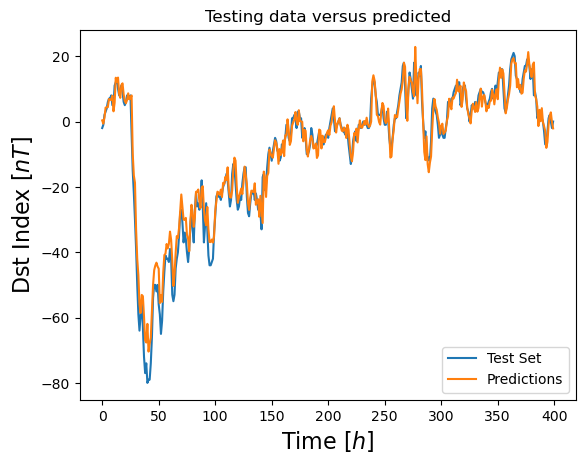

In [47]:
prediction = model_used.predict(x_test)
Y_test=np.concatenate(x_test)

m0 = int(m_testn/4)
m1 = min(m0+400,m_testn)


plt.title('Testing data versus predicted')
plt.plot(y_test[m0:m1], label='Test Set')
plt.plot(prediction[m0:m1], label='Predictions')
plt.legend()
plt.xlabel('Time $[h]$',fontsize=16)
plt.ylabel('Dst Index $[nT]$',fontsize=16)
plt.show()
